# Product Clustering for Recommendation based on Customer Insights, Profiling and Customer Satisfaction

##Data Preprocessing and feature extraction for Clustering products

In [1]:
%%bash
pip install stemming

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stemming: filename=stemming-1.0.1-py3-none-any.whl size=11138 sha256=729f66f61304c4edeb6e72b4c132d06a424a2b7f1362c79abce5bf8779e932c3
  Stored in directory: /root/.cache/pip/wheels/6b/e5/e2/c52ebc0a5b53fd82b00cc385e57bb1c90bd50e5f54ddbc06d1
Successfully built stemming


In [2]:
import string
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from stemming.porter2 import stem
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

In [4]:
!gdown --id 1-MyYRp_5NnmU1JWvl1jV6Dhe3o2HAjdc

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-MyYRp_5NnmU1JWvl1jV6Dhe3o2HAjdc
To: /content/amazon-meta.txt
100% 978M/978M [00:04<00:00, 235MB/s]


### Open the file to read Amazon Product Metadata

In [5]:
df = open ('/content/amazon-meta.txt', 'r', encoding='utf-8', errors= 'ignore')

### Initialize a nested product dictionary that will hold cleaned up amazon product data. 

In [6]:
amazonProducts= {}

### Read the data from the Amazon meta information file and fill the AmazonProducts nested dictionary with features of products and extracted features of users reviews

In [7]:
(Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff,helpf,votes) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0,0,0)
for line in df:
    line = line.strip()
    if(line.startswith("Id")):
        Id = line[3:].strip()
        counter = 0
    elif(line.startswith("ASIN")):
        ASIN = line[5:].strip()
    elif(line.startswith("group")):
        Group = line[6:].strip()
    elif(line.startswith("title")):
        Title = line[6:].strip()
        Title = ' '.join(Title.split())
    elif(line.startswith("salesrank")):
        SalesRank = line[10:].strip()
    elif(line.startswith("reviews")):
        ls = line.split()
        TotalReviews = ls[2].strip()
        AvgRating = ls[7].strip()
    elif(line.startswith("19")):
        ls = line.split()
        votes=votes+int(ls[6].strip()) #aggreating votes number
        helpf=helpf+int(ls[8].strip()) #aggregating helpful votes number
    elif(line.startswith("20")):
        ls = line.split()
        votes=votes+int(ls[6].strip()) #aggreating votes number
        helpf=helpf+int(ls[8].strip()) #aggregating helpful votes number
    elif(line.startswith("categories")):
        ls = line.split() #aggregating categories to a list
        Categories = ' '.join((df.readline()).lower() for i in range(int(ls[1].strip())))
        Categories = re.compile('[%s]' % re.escape(string.digits+string.punctuation)).sub(' ',Categories)
        Categories = ' '.join(set(Categories.split())-set(stopwords.words("english")))
        Categories = ' '.join(stem(word) for word in Categories.split())
    elif (line==""): # write out fields to amazonProducts dictionary
        try:
            MetaData = {}
            if (ASIN != ""):
                amazonProducts[ASIN] = MetaData
            MetaData['Id'] = Id
            MetaData['Title'] = Title
            MetaData['Categories'] = ' '.join(set(Categories.split()))
            MetaData['Group'] = Group
            MetaData['SalesRank'] = int(SalesRank)
            MetaData['TotalReviews'] = int(TotalReviews)
            MetaData['AvgRating'] = float(AvgRating)
            MetaData['Helpful'] = int(helpf)
            MetaData['Votes'] = int(votes)
        except NameError:
            continue
        (Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff,helpf,votes) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0,0,0)
df.close

<function TextIOWrapper.close>

###Converting Dictionary to Dataframe

In [8]:
df = pd.DataFrame.from_dict(amazonProducts)
df = df.T

####Unique Groups of Products Available

In [9]:
df.Group.unique()

array(['', 'Book', 'Music', 'DVD', 'Video', 'Toy', 'Video Games',
       'Software', 'Baby Product', 'CE', 'Sports'], dtype=object)

####Checking for null data items

In [10]:
df.isnull().sum()

Id              0
Title           0
Categories      0
Group           0
SalesRank       0
TotalReviews    0
AvgRating       0
Helpful         0
Votes           0
dtype: int64

####Checking Distribution of Various Groups of Products

In [11]:
df['Group'].value_counts()

Book            393561
Music           103144
Video            26131
DVD              19828
                  5868
Toy                  8
Software             5
CE                   4
Video Games          1
Baby Product         1
Sports               1
Name: Group, dtype: int64

#### **We can conclude from above that product groups apart from Book,Music,Video and DVD other categories are very insignificant in number and we ignore them**

In [12]:
df = df[(df['Group'] == 'Book') | (df['Group'] == 'Music') | (df['Group'] == 'Video') | (df['Group'] == 'DVD')]

#### **Finding Number of Non-Helpful Votes**

In [13]:
df['NonHelpfulVotes']=df['Votes']-df['Helpful']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
df['ASIN'] = df.index
df1 = df.set_index('Id')
df1['Helpful'] = df1['Helpful'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


####Checking Distribution of Helpful Votes of Products to evaluate number of bins we can group them into

In [15]:
df1['Helpful'].describe()

count    542664.000000
mean         53.096802
std         266.525417
min           0.000000
25%           0.000000
50%           8.000000
75%          35.000000
max       27354.000000
Name: Helpful, dtype: float64

In [16]:
df1=df1.reset_index()

#### Visualization of Helpful ratings over samples of 100000 datapoints to visualize the distribution in samples

In [17]:
df2 = df1[0:100000]
print(df2['Helpful'].describe())
df2 = df1[100000:200000]
print(df2['Helpful'].describe())
df2 = df1[200000:300000]
print(df2['Helpful'].describe())
df2 = df1[300000:400000]
print(df2['Helpful'].describe())
df2 = df1[400000:]
print(df2['Helpful'].describe())
df2 = df1[400000:]
df2['AvgRating']=df2['AvgRating'].astype(float)
print(df2.groupby('AvgRating').count())
#print(df2.groupby('label_code').count())

count    100000.000000
mean         53.414440
std         274.804652
min           0.000000
25%           0.000000
50%           8.000000
75%          35.000000
max       27354.000000
Name: Helpful, dtype: float64
count    100000.000000
mean         53.023110
std         268.220622
min           0.000000
25%           0.000000
50%           8.000000
75%          34.000000
max       24783.000000
Name: Helpful, dtype: float64
count    100000.000000
mean         51.904310
std         248.348625
min           0.000000
25%           0.000000
50%           8.000000
75%          34.000000
max       25287.000000
Name: Helpful, dtype: float64
count    100000.000000
mean         48.587200
std         276.150735
min           0.000000
25%           0.000000
50%           7.000000
75%          30.000000
max       27297.000000
Name: Helpful, dtype: float64
count    142664.000000
mean         56.922678
std         264.819862
min           0.000000
25%           0.000000
50%          10.000000
75%   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


              Id  Title  Categories  Group  SalesRank  TotalReviews  Helpful  \
AvgRating                                                                      
0.0        30920  30920       30920  30920      30920         30920    30920   
1.0          803    803         803    803        803           803      803   
1.5          250    250         250    250        250           250      250   
2.0         1166   1166        1166   1166       1166          1166     1166   
2.5         1985   1985        1985   1985       1985          1985     1985   
3.0         5995   5995        5995   5995       5995          5995     5995   
3.5         9711   9711        9711   9711       9711          9711     9711   
4.0        23135  23135       23135  23135      23135         23135    23135   
4.5        28547  28547       28547  28547      28547         28547    28547   
5.0        40152  40152       40152  40152      40152         40152    40152   

           Votes  NonHelpfulVotes   ASI

#### **Categorizing Products into 3 clusters based on customer insights based on the distribution of helpful rating**

In [18]:
df1['label_code'] = pd.cut(x=df1['Helpful'], bins=[-1, 8, 35, 27355], labels=['0', '1', '2'])

####One Hot Encoding the Groups of Products

In [19]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df1[['Group']]).toarray())
df1 = df1.join(encoder_df)

In [20]:
df1=df1.drop('Group',axis=1)

In [21]:
df1['label_code']=df1['label_code'].astype(int)

### Saving the dataframe for Future Use 

In [22]:
df1.to_csv("/content/customer_insights_recommendations.csv")

## Recommendation based on Customer Insights Cluster and Category Similarity

### In order to compare similarity between 2 products we compute similarity between category to which they belongs by finding jaccard similarity metric between 2 categories

In [23]:
df1.head()

,Id,Title,Categories,SalesRank,TotalReviews,AvgRating,Helpful,Votes,NonHelpfulVotes,ASIN,label_code,0,1,2,3
0,1,Patterns of Preaching: A Sermon Sampler,clergi sermon preach religion spiritu book sub...,396585,2,5.0,14,16,2,0827229534,1,1.0,0.0,0.0,0.0
1,2,Candlemas: Feast of Flames,base earth religion spiritu witchcraft book su...,168596,12,4.5,76,84,8,0738700797,2,1.0,0.0,0.0,0.0
2,3,World War II Allied Fighter Planes Trading Cards,general garden home craft hobbi book subject,1270652,1,5.0,2,2,0,0486287785,0,1.0,0.0,0.0,0.0
3,4,Life Application Bible Commentary: 1 and 2 Tim...,general translat new guid histori christian li...,631289,1,4.0,1,1,0,0842328327,0,1.0,0.0,0.0,0.0
4,5,Prayers That Avail Much for Business: Executive,devot worship prayerbook busi religion spiritu...,455160,0,0.0,0,0,0,1577943082,0,1.0,0.0,0.0,0.0



###The Jaccard Index
also known as the Jaccard similarity coefficient, is a statistic used in understanding the similarities between sample sets. The measurement emphasizes similarity between finite sample sets, and is formally defined as the size of the intersection divided by the size of the union of the sample sets. The mathematical representation of the index is written as:

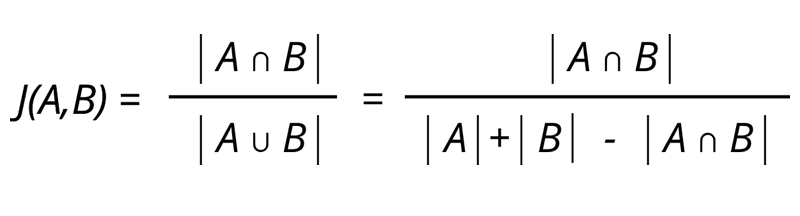

In [24]:
def jaccard(a, b):
    a = set((str(a)).split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [25]:
def prod_label_recommj(x_counter):
  # get label of asin
  df_counter = df1.loc[df1['ASIN'] == x_counter]
  x = int(df_counter['label_code'])
  y = set((str(df_counter['Categories'])).split())
  df_counter = df1.loc[df1['label_code'] == x]
  df_counter = df_counter.loc[df_counter['AvgRating']>=4.5]
  df_counter['score_cat_inter']= df_counter['Categories'].apply(lambda x: jaccard(x,y))
  sorted_df = df_counter.sort_values(["score_cat_inter"], ascending=False)
  return sorted_df[1:6]['ASIN'].tolist()


#### Testing the recommendations for giving Product Id

In [26]:
X = prod_label_recommj('B00008DDST')
print(X)

['B00005IB9M', 'B00008975P', '6305944571', '6305475997', 'B0000694VT']


###The Sørensen-Dice index 
is very similar to Jaccard index in that it measures the similarity and diversity of sample sets. Although they are calculated similarly the Sørensen-Dice index is a bit more intuitive because it can be seen as the percentage of overlap between two sets, which is a value between 0 and 1:

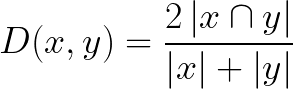

In [27]:
def sordice(a, b):
    a = set((str(a)).split())
    c = a.intersection(b)
    d = float(1-(2*len(c)/((2*len(c))+len(a.difference(b))+len(b.difference(a)))))
    return d

In [28]:
def prod_label_recomms(x_counter):
  # get label of asin
  df_counter = df1.loc[df1['ASIN'] == x_counter]
  x = int(df_counter['label_code'])
  y = set((str(df_counter['Categories'])).split())
  df_counter = df1.loc[df1['label_code'] == x]
  df_counter = df_counter.loc[df_counter['AvgRating']>=4.5]
  df_counter['score_cat_inter']= df_counter['Categories'].apply(lambda x: sordice(x,y))
  sorted_df = df_counter.sort_values(["score_cat_inter"])
  return sorted_df[1:6]['ASIN'].tolist()


#### Testing the recommendations for giving Product Id

In [29]:
X = prod_label_recomms('B00008DDST')
print(X)

['B00005IB9M', '6305944571', 'B00008975P', '6305475997', 'B0000694VT']


### Recommending Products based on Customer Insights based on similarities of categories of products using Jaccard and Sørensen-Dice index 

In [30]:
def Union(lst1, lst2):
    final_list = list(set(lst1) | set(lst2))
    return final_list

In [31]:
def prod_label_recomm_u(x_counter):
  x = prod_label_recommj(x_counter)
  y = prod_label_recomms(x_counter)
  z = Union(x,y)
  return z


#### Testing the recommendations for giving Product Id

In [32]:
X = prod_label_recomm_u('B00008DDST')
print(X)

['B00005IB9M', 'B0000694VT', 'B00008975P', '6305944571', '6305475997']


###Extracting Top-10 products in each graph cluster based on Avg Rating,Helpful and NonHelpfulVotes

In [33]:
df_counter = df1.copy()

In [34]:
df_counter['Helpful-Votes']=df_counter['Helpful']-df_counter['Votes']
df_counter = df_counter.sort_values(["AvgRating","Helpful","NonHelpfulVotes"], ascending=False)

In [35]:
df_counter0 = df_counter.loc[df_counter['label_code'] == 0]
df_counter0[:10]

,Id,Title,Categories,SalesRank,TotalReviews,AvgRating,Helpful,Votes,NonHelpfulVotes,ASIN,label_code,0,1,2,3,Helpful-Votes
315646,319314,Change Your Child's Behavior by Changing Yours...,general parent disciplin book subject famili,392117,1,5.0,8,81,73,0517884631,0,1.0,0.0,0.0,0.0,-73
37201,37632,Practical Aspects of Interview and Interrogati...,general subject book refer,731029,5,5.0,8,51,43,0849395208,0,1.0,0.0,0.0,0.0,-43
213137,215571,Practical Aspects of Interview and Interrogati...,general procedur nonfict profession technic cr...,165545,5,5.0,8,51,43,0849301017,0,1.0,0.0,0.0,0.0,-43
473759,479187,Results-Oriented Job Descriptions: More Than 2...,general amazon resourc industri career personn...,472319,3,5.0,8,49,41,0814478069,0,1.0,0.0,0.0,0.0,-41
505771,511587,Decorative Letters CD-ROM and Book (Dover Elec...,general graphic design art photographi ornamen...,130537,4,5.0,8,45,37,0486999424,0,1.0,0.0,0.0,0.0,-37
48115,48645,Log Cabins (Architecture and Design Library),general garden photographi architectur essay p...,489670,1,5.0,8,43,35,1567997236,0,1.0,0.0,0.0,0.0,-35
218064,220551,Berlioz: Symphonie fantastique,general symphoni music amazon hector b bargain...,9463,4,5.0,8,42,34,B000003FI2,0,0.0,0.0,1.0,0.0,-34
237457,240151,Smith & Hawken: Hands On Gardener: Composting ...,general garden home horticultur techniqu book ...,271609,3,5.0,8,40,32,0761107320,0,1.0,0.0,0.0,0.0,-32
292791,296125,"Beauty in Exile: The Artists, Models, and Nobi...",general garden fashion design art photographi ...,315890,2,5.0,8,39,31,0810957019,0,1.0,0.0,0.0,0.0,-31
11607,11718,Grammar Wars: 179 Games and Improvs for Learni...,general word grammar book subject languag comm...,457522,4,5.0,8,38,30,1566080630,0,1.0,0.0,0.0,0.0,-30


In [36]:
df_counter1 = df_counter.loc[df_counter['label_code'] == 1]
df_counter1[:10]

,Id,Title,Categories,SalesRank,TotalReviews,AvgRating,Helpful,Votes,NonHelpfulVotes,ASIN,label_code,0,1,2,3,Helpful-Votes
75281,76090,Visualizing Data,general subject book refer,230851,4,5.0,35,101,66,0963488406,1,1.0,0.0,0.0,0.0,-66
75823,76634,Remembering Farley,general humor graphic entertain book comic sub...,458983,7,5.0,35,91,56,0836213092,1,1.0,0.0,0.0,0.0,-56
369171,373415,Northrop Frye on Shakespeare,general world fiction z author f shakespear cr...,64522,5,5.0,35,87,52,0300042086,1,1.0,0.0,0.0,0.0,-52
252929,255813,Zappa in N.Y.,progress indi album specialti music style live...,13162,14,5.0,35,81,46,B0000009SS,1,0.0,0.0,1.0,0.0,-46
230823,233445,Where the Birds Are: The 100 Best Birdwatching...,general field bird guid natur book subject out...,555781,3,5.0,35,73,38,0789471698,1,1.0,0.0,0.0,0.0,-38
103406,104550,The Wasp Cookbook,general humor intern food entertain cook u reg...,68170,10,5.0,35,72,37,0446912107,1,1.0,0.0,0.0,0.0,-37
257239,260175,The Supreme Court's Greatest Hits,general cd technic profession system constitut...,615037,11,5.0,35,70,35,0810116642,1,1.0,0.0,0.0,0.0,-35
378536,382890,I Know Why the Caged Bird Sings (Cliffs Notes),educ note book subject refer,197842,8,5.0,35,70,35,0822006413,1,1.0,0.0,0.0,0.0,-35
182540,184516,"Color, Environment, & Human Response",general garden textbook new architectur enviro...,313182,2,5.0,35,68,33,0471286672,1,1.0,0.0,0.0,0.0,-33
49338,49881,Miles to Go,general indi specialti music style pop store a...,193752,12,5.0,35,67,32,B00006OAO2,1,0.0,0.0,1.0,0.0,-32


In [37]:
df_counter2 = df_counter.loc[df_counter['label_code'] == 2]
df_counter2[:10]

,Id,Title,Categories,SalesRank,TotalReviews,AvgRating,Helpful,Votes,NonHelpfulVotes,ASIN,label_code,0,1,2,3,Helpful-Votes
224194,226761,Thief of Hearts,general sleuth women mysteri book subject thri...,168904,276,5.0,7959,8702,743,1588515591,2,1.0,0.0,0.0,0.0,-743
83949,84842,Harry Potter and the Goblet of Fire (Book 4 Au...,general humor potter author tape audio j seri ...,661,4924,5.0,6871,13975,7104,0807282596,2,1.0,0.0,0.0,0.0,-7104
538454,544342,"Harry Potter and the Goblet of Fire (Book 4, A...",general humor potter author tape audio j seri ...,5031,4924,5.0,6801,13659,6858,0807282588,2,1.0,0.0,0.0,0.0,-6858
521437,527309,Harry Potter and the Goblet of Fire (Book 4),general potter author j seri illustr z book su...,404,4924,5.0,6796,13646,6850,0439139600,2,1.0,0.0,0.0,0.0,-6850
424249,429123,Harry Potter and the Goblet of Fire (Book 4),general humor potter author j seri illustr har...,327,4924,5.0,6795,13691,6896,0439139597,2,1.0,0.0,0.0,0.0,-6896
307787,311376,Harry Potter and the Goblet of Fire (Book 4),general humor potter author j print seri illus...,285760,4924,5.0,6795,13617,6822,0786229276,2,1.0,0.0,0.0,0.0,-6822
4692,4739,Harry Potter and the Goblet of Fire (Book 4),general potter author j seri illustr z book su...,868892,4921,5.0,6696,13572,6876,0939173379,2,1.0,0.0,0.0,0.0,-6876
526432,532306,Looking For-Best of David Hasselhoff,general music style broadway vocalist,176907,1084,5.0,6500,7363,863,B0000070S1,2,0.0,0.0,1.0,0.0,-863
248073,250879,Harry Potter and the Sorcerer's Stone (Book 1 ...,general humor potter author tape audio j seri ...,990191,5039,5.0,5815,9924,4109,0807286001,2,1.0,0.0,0.0,0.0,-4109
209087,211463,Harry Potter and the Sorcerer's Stone (Book 1 ...,general humor potter author tape audio j seri ...,1533,5039,5.0,5813,10037,4224,0807281956,2,1.0,0.0,0.0,0.0,-4224
